<a href="https://www.kaggle.com/code/dewizzz/lalalayeyeyelulusfixed?scriptVersionId=138655296" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="background-color:#F0E68C;font-family:Halvetica;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Deteksi Autisme</b></h1>

In [21]:
import os
import time
import torch
import seaborn as sn
import pandas as pd
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm
import torch.nn.functional as F

# **Load Data**

In [22]:
# Path ke folder kelas 1
folder_kelas_1 = '/kaggle/input/data-skripsi/Data Skripsi/Kelas Autisme'

# Path ke folder kelas 0
folder_kelas_0 = '/kaggle/input/data-skripsi/Data Skripsi/Kelas TC'

# Inisialisasi dictionary untuk menyimpan label
label_gambar = {}

# Melabeli gambar-gambar dalam folder kelas 1
for file in os.listdir(folder_kelas_1):
    if file.endswith('.gif'):
        label_gambar[file] = 1  # Label kelas 1

# Melabeli gambar-gambar dalam folder kelas 0
for file in os.listdir(folder_kelas_0):
    if file.endswith('.gif'):
        label_gambar[file] = 0  # Label kelas 0

In [23]:
# Mencetak hasil labeling untuk 5 gambar dari setiap kelas
count_kelas_0 = 0
count_kelas_1 = 0

for file, label in label_gambar.items():
    if label == 0 and count_kelas_0 < 5:
        print(f"File: {file}, Label: {label}")
        count_kelas_0 += 1
    elif label == 1 and count_kelas_1 < 5:
        print(f"File: {file}, Label: {label}")
        count_kelas_1 += 1
    
    if count_kelas_0 == 5 and count_kelas_1 == 5:
        break

File: GU_28824_1.gif, Label: 1
File: UCD_30014_1.gif, Label: 1
File: GU_28818_1.gif, Label: 1
File: SDSU_28873_1.gif, Label: 1
File: KUL_29800_1.gif, Label: 1
File: GU_28757_1.gif, Label: 0
File: KKI_29470_1.gif, Label: 0
File: KKI_29295_1.gif, Label: 0
File: KKI_29329_1.gif, Label: 0
File: OHSU_28950_1.gif, Label: 0


In [24]:
# Transformasi untuk data gambar GIF
class GIFToTensor(object):
    def __call__(self, pic):
        if pic.mode != 'RGB':
            pic = pic.convert('RGB')
        return transforms.ToTensor()(pic)

# Transformasi data
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    GIFToTensor(),
])

# Proses transformasi dan penyimpanan data
data = []

for file, label in label_gambar.items():
    # Baca gambar dan aplikasikan transformasi
    img_path = os.path.join(folder_kelas_1 if label == 1 else folder_kelas_0, file)
    image = Image.open(img_path)
    transformed_image = transform(image)
    
    # Simpan data dan label ke dalam list
    data.append((transformed_image, label))

# **Split Data**

In [25]:
# Bagi data menjadi set pelatihan dan set pengujian
train_data, test_data, train_labels, test_labels = train_test_split(
    [item[0] for item in data],  # Data gambar
    [item[1] for item in data],  # Label
    test_size=0.3,  # Proporsi set pengujian
    random_state=42  # Seed untuk reproduktibilitas
)

# Cetak jumlah data dalam set pelatihan dan set pengujian
print(f"Jumlah data pelatihan: {len(train_data)}")
print(f"Jumlah data pengujian: {len(test_data)}")

Jumlah data pelatihan: 747
Jumlah data pengujian: 321


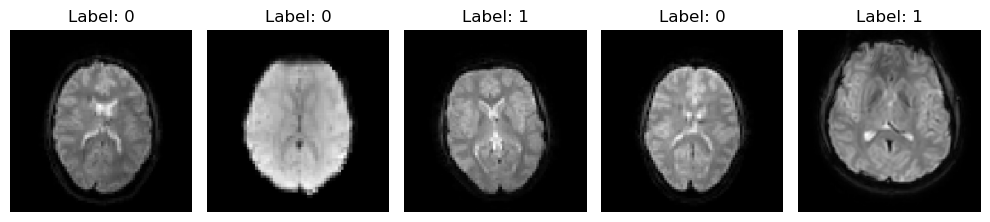

In [26]:
# Menampilkan 5 gambar dari set pelatihan
fig, axes = plt.subplots(1, 5, figsize=(10, 4))

for i, ax in enumerate(axes):
    img = train_data[i].permute(1, 2, 0)  # Mengubah dimensi tensor menjadi (H, W, C)
    label = train_labels[i]
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# **Split Data Train - Val**

In [27]:
# Memisahkan data pelatihan menjadi data validasi dan data pelatihan baru
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data,  # Data pelatihan yang sudah ada
    train_labels,  # Label pelatihan yang sudah ada
    test_size=0.3,  # Proporsi data validasi
    random_state=42  # Seed untuk reproduktibilitas
)

# Cetak jumlah data dalam set pelatihan dan set pengujian
print(f"Jumlah data pelatihan: {len(train_data)}")
print(f"Jumlah data pengujian: {len(val_data)}")

Jumlah data pelatihan: 522
Jumlah data pengujian: 225


# Perbaikan pixel (buat jaga-jaga)

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Tentukan ukuran resolusi yang diinginkan
new_size = 448

# Definisikan transformasi untuk meningkatkan resolusi gambar
upscale_transform = transforms.Resize((new_size, new_size))

upscaled_train_data = []
for image_tensor in train_data:
    # Lakukan peningkatan skala gambar
    upscaled_image_tensor = upscale_transform(image_tensor)

    # Tambahkan gambar yang telah ditingkatkan ke dalam data latih yang baru
    upscaled_train_data.append(upscaled_image_tensor)
    
upscaled_val_data = []
for image_tensor in val_data:
    upscaled_image_tensor = upscale_transform(image_tensor)
    upscaled_val_data.append(upscaled_image_tensor)

upscaled_test_data = []
for image_tensor in test_data:
    upscaled_image_tensor = upscale_transform(image_tensor)
    upscaled_test_data.append(upscaled_image_tensor)

import matplotlib.pyplot as plt
import numpy as np

# Menampilkan beberapa gambar asli dan hasil peningkatan skala
num_images = 5  # Jumlah gambar yang ingin ditampilkan
fig, axes = plt.subplots(num_images, 2, figsize=(8, 2*num_images))

for i in range(num_images):
    # Gambar asli
    original_image = train_data[i]
    original_image_rgb = np.transpose(original_image, (1, 2, 0))
    axes[i, 0].imshow(original_image_rgb)
    axes[i, 0].set_title('Original')

    # Hasil peningkatan skala
    upscaled_image = upscaled_train_data[i]
    upscaled_image_rgb = np.transpose(upscaled_image, (1, 2, 0))
    axes[i, 1].imshow(upscaled_image_rgb)
    axes[i, 1].set_title('Upscaled')

plt.tight_layout()
plt.show()

> # ===== Batas jaga-jaga =====

train_dataset = list(zip(upscaled_train_data, train_labels))
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = list(zip(upscaled_val_data, val_labels))
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

test_dataset = list(zip(upscaled_test_data, test_labels))
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [28]:
train_dataset = list(zip(train_data, train_labels))
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = list(zip(val_data, val_labels))
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

test_dataset = list(zip(test_data, test_labels))
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [29]:
# Menginisialisasi model pretrained
model = models.vgg16(pretrained=True)

# Menonaktifkan penghitungan gradien untuk parameter model pretrained
for param in model.parameters():
    param.requires_grad = False

# Mengubah ukuran input pada lapisan konvolusi pertama
model.features[0] = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

# Mengganti layer terakhir (fully connected) pada model dengan layer baru
num_classes = 2  # Jumlah kelas
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
# Menggunakan perangkat GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [32]:
# Mendifinisikan fungsi loss dan optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# **Train Model**

In [33]:
from sklearn.model_selection import KFold

train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

def train(model, device, train_loader, optimizer, epoch, train_indices, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    running_loss = 0.0
    running_corrects = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        logits = output
        output = F.softmax(output, dim=1)
        _, preds = torch.max(output, dim=1)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
        running_loss += loss.item()
        running_corrects += torch.sum(preds == target).item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects / len(train_indices)  # Use len(train_indices) instead of len(train_loader.dataset)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    print(epoch_loss)
    print(epoch_acc)


def val(model, device, val_loader, val_indices):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits = output
            val_loss += criterion(logits, target).item() # sum up batch loss
            pred_prob = torch.softmax(logits, dim=1) # apply softmax to output
            pred_class = torch.argmax(pred_prob, dim=1) # get the index of the max probability
            correct += pred_class.eq(target.view_as(pred_class)).sum().item()
    val_acc= correct/len(val_indices)  # Use len(val_indices) instead of len(val_loader.dataset)
    val_loss /= len(val_loader)
    valid_loss.append(val_loss)
    valid_accuracy.append(val_acc)
    print(val_loss)
    print(val_acc)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_indices),
        100. * correct / len(val_indices)))  # Use len(val_indices) instead of len(val_loader.dataset)

In [34]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)
epochs = 30
batch_size = 30

train_loss_per_fold = []
train_accuracy_per_fold = []
valid_loss_per_fold = []
valid_accuracy_per_fold = []

start_time = time.time()

for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{kf.get_n_splits()}")  # Using kf.get_n_splits() to get the number of splits

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, epoch, train_indices)
        val(model, device, val_loader, val_indices)

    # Store the outputs for each fold
    train_loss_per_fold.append(train_loss)
    train_accuracy_per_fold.append(train_accuracy)
    valid_loss_per_fold.append(valid_loss)
    valid_accuracy_per_fold.append(valid_accuracy)

print("--- %s seconds ---" % (time.time() - start_time))


Fold 1/4


  0%|          | 0/14 [00:00<?, ?it/s]

0.7154992180211204
0.4833759590792839
0.6897812843322754
0.5190839694656488

Test set: Average loss: 0.6898, Accuracy: 68/131 (52%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.7105315327644348
0.5268542199488491
0.6856060028076172
0.5190839694656488

Test set: Average loss: 0.6856, Accuracy: 68/131 (52%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.703719858612333
0.5140664961636828
0.6869177460670471
0.6183206106870229

Test set: Average loss: 0.6869, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.7012239652020591
0.5191815856777494
0.6888743996620178
0.5114503816793893

Test set: Average loss: 0.6889, Accuracy: 67/131 (51%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6771943484033857
0.5447570332480819
0.6813903450965881
0.6106870229007634

Test set: Average loss: 0.6814, Accuracy: 80/131 (61%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6929583081177303
0.5652173913043478
0.6825674414634705
0.6106870229007634

Test set: Average loss: 0.6826, Accuracy: 80/131 (61%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.715123747076307
0.5677749360613811
0.6855763912200927
0.5801526717557252

Test set: Average loss: 0.6856, Accuracy: 76/131 (58%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6669182692255292
0.5626598465473146
0.6818374991416931
0.6183206106870229

Test set: Average loss: 0.6818, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6671389128480639
0.5856777493606138
0.681035852432251
0.5801526717557252

Test set: Average loss: 0.6810, Accuracy: 76/131 (58%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6827215211732047
0.5626598465473146
0.6789817094802857
0.5877862595419847

Test set: Average loss: 0.6790, Accuracy: 77/131 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6948416914258685
0.5805626598465473
0.6737268805503845
0.5648854961832062

Test set: Average loss: 0.6737, Accuracy: 74/131 (56%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6722860847200666
0.5856777493606138
0.6798893928527832
0.5648854961832062

Test set: Average loss: 0.6799, Accuracy: 74/131 (56%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.691696069070271
0.5933503836317136
0.6711552023887635
0.5648854961832062

Test set: Average loss: 0.6712, Accuracy: 74/131 (56%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6501926013401577
0.5882352941176471
0.6912202000617981
0.5877862595419847

Test set: Average loss: 0.6912, Accuracy: 77/131 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6716512952532087
0.6086956521739131
0.6711385607719421
0.5877862595419847

Test set: Average loss: 0.6711, Accuracy: 77/131 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6663601015295301
0.5959079283887468
0.669268524646759
0.5877862595419847

Test set: Average loss: 0.6693, Accuracy: 77/131 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6738154803003583
0.578005115089514
0.6830295324325562
0.6030534351145038

Test set: Average loss: 0.6830, Accuracy: 79/131 (60%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.676542763199125
0.578005115089514
0.6669885039329528
0.5877862595419847

Test set: Average loss: 0.6670, Accuracy: 77/131 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6326387631041663
0.59846547314578
0.6693581581115723
0.5954198473282443

Test set: Average loss: 0.6694, Accuracy: 78/131 (60%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6749875247478485
0.6061381074168798
0.6656973481178283
0.5572519083969466

Test set: Average loss: 0.6657, Accuracy: 73/131 (56%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6491656516279493
0.5907928388746803
0.6574955940246582
0.5877862595419847

Test set: Average loss: 0.6575, Accuracy: 77/131 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6428789624146053
0.6010230179028133
0.6660351276397705
0.5801526717557252

Test set: Average loss: 0.6660, Accuracy: 76/131 (58%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6699176984173911
0.5805626598465473
0.6636645197868347
0.6030534351145038

Test set: Average loss: 0.6637, Accuracy: 79/131 (60%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6569385869162423
0.6112531969309463
0.6553904414176941
0.5572519083969466

Test set: Average loss: 0.6554, Accuracy: 73/131 (56%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6574530048029763
0.6010230179028133
0.6611292362213135
0.5801526717557252

Test set: Average loss: 0.6611, Accuracy: 76/131 (58%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6761949786118099
0.59846547314578
0.6633026599884033
0.5877862595419847

Test set: Average loss: 0.6633, Accuracy: 77/131 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6454103376184191
0.6317135549872123
0.6694165349006653
0.5954198473282443

Test set: Average loss: 0.6694, Accuracy: 78/131 (60%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6465218322617667
0.5933503836317136
0.6625497817993165
0.5572519083969466

Test set: Average loss: 0.6625, Accuracy: 73/131 (56%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6431129659925189
0.6163682864450127
0.66219242811203
0.5801526717557252

Test set: Average loss: 0.6622, Accuracy: 76/131 (58%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6898154062884194
0.6035805626598465
0.6652148008346558
0.5572519083969466

Test set: Average loss: 0.6652, Accuracy: 73/131 (56%)

Fold 2/4


  0%|          | 0/14 [00:00<?, ?it/s]

0.6834591371672494
0.6086956521739131
0.6426902174949646
0.6335877862595419

Test set: Average loss: 0.6427, Accuracy: 83/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6553225964307785
0.618925831202046
0.6329151868820191
0.6259541984732825

Test set: Average loss: 0.6329, Accuracy: 82/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.689140362398965
0.5728900255754475
0.6250346958637237
0.6183206106870229

Test set: Average loss: 0.6250, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6916116178035736
0.6010230179028133
0.6453993201255799
0.648854961832061

Test set: Average loss: 0.6454, Accuracy: 85/131 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6710830969469888
0.5882352941176471
0.6502685785293579
0.6259541984732825

Test set: Average loss: 0.6503, Accuracy: 82/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6361729566540036
0.6317135549872123
0.6391008019447326
0.6412213740458015

Test set: Average loss: 0.6391, Accuracy: 84/131 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.646197076354708
0.6214833759590793
0.6444828748703003
0.6335877862595419

Test set: Average loss: 0.6445, Accuracy: 83/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6439089817660195
0.6035805626598465
0.6562292098999023
0.6335877862595419

Test set: Average loss: 0.6562, Accuracy: 83/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6945462610040393
0.6214833759590793
0.6435037851333618
0.648854961832061

Test set: Average loss: 0.6435, Accuracy: 85/131 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6459464068923678
0.6138107416879796
0.6547504782676696
0.6335877862595419

Test set: Average loss: 0.6548, Accuracy: 83/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6419705195086343
0.6163682864450127
0.638521134853363
0.648854961832061

Test set: Average loss: 0.6385, Accuracy: 85/131 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.666674371276583
0.6342710997442456
0.6460900068283081
0.6183206106870229

Test set: Average loss: 0.6461, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6634023615292141
0.6112531969309463
0.6311758279800415
0.6412213740458015

Test set: Average loss: 0.6312, Accuracy: 84/131 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6298223457166127
0.6470588235294118
0.6471070647239685
0.6335877862595419

Test set: Average loss: 0.6471, Accuracy: 83/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6542259327002934
0.6342710997442456
0.6440232396125793
0.6183206106870229

Test set: Average loss: 0.6440, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6710173743111747
0.5524296675191815
0.6510342836380005
0.6412213740458015

Test set: Average loss: 0.6510, Accuracy: 84/131 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6533776436533246
0.6010230179028133
0.6497335076332093
0.6183206106870229

Test set: Average loss: 0.6497, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6598918863705227
0.5907928388746803
0.6466256737709045
0.6183206106870229

Test set: Average loss: 0.6466, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6352968513965607
0.629156010230179
0.640676748752594
0.648854961832061

Test set: Average loss: 0.6407, Accuracy: 85/131 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6211961763245719
0.6521739130434783
0.6280550003051758
0.6259541984732825

Test set: Average loss: 0.6281, Accuracy: 82/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6441579929419926
0.6138107416879796
0.6482360243797303
0.6335877862595419

Test set: Average loss: 0.6482, Accuracy: 83/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.643629619053432
0.6317135549872123
0.6569086313247681
0.6412213740458015

Test set: Average loss: 0.6569, Accuracy: 84/131 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6395159576620374
0.618925831202046
0.671467912197113
0.6412213740458015

Test set: Average loss: 0.6715, Accuracy: 84/131 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6431732199021748
0.6163682864450127
0.6540252089500427
0.6183206106870229

Test set: Average loss: 0.6540, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6657968291214534
0.6086956521739131
0.6413830399513245
0.6259541984732825

Test set: Average loss: 0.6414, Accuracy: 82/131 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.677332090479987
0.59846547314578
0.65597505569458
0.6412213740458015

Test set: Average loss: 0.6560, Accuracy: 84/131 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6361780166625977
0.6342710997442456
0.6650164127349854
0.6183206106870229

Test set: Average loss: 0.6650, Accuracy: 81/131 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6291763356753758
0.618925831202046
0.6358964920043946
0.6106870229007634

Test set: Average loss: 0.6359, Accuracy: 80/131 (61%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.7316444601331439
0.5933503836317136
0.6240003645420075
0.6412213740458015

Test set: Average loss: 0.6240, Accuracy: 84/131 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6862575284072331
0.5933503836317136
0.6616309642791748
0.6259541984732825

Test set: Average loss: 0.6616, Accuracy: 82/131 (63%)

Fold 3/4


  0%|          | 0/14 [00:00<?, ?it/s]

0.6601965512548175
0.6096938775510204
0.6223642826080322
0.6923076923076923

Test set: Average loss: 0.6224, Accuracy: 90/130 (69%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.63400485260146
0.6224489795918368
0.6310673952102661
0.6615384615384615

Test set: Average loss: 0.6311, Accuracy: 86/130 (66%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6501812977450234
0.625
0.6177659392356872
0.6846153846153846

Test set: Average loss: 0.6178, Accuracy: 89/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.7003161779471806
0.5994897959183674
0.621227502822876
0.6692307692307692

Test set: Average loss: 0.6212, Accuracy: 87/130 (67%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6474528312683105
0.6326530612244898
0.6453109383583069
0.5923076923076923

Test set: Average loss: 0.6453, Accuracy: 77/130 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6697481061731066
0.6224489795918368
0.6432407855987549
0.6307692307692307

Test set: Average loss: 0.6432, Accuracy: 82/130 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6701779280390058
0.6071428571428571
0.6353120326995849
0.6923076923076923

Test set: Average loss: 0.6353, Accuracy: 90/130 (69%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6458440550736019
0.6224489795918368
0.6299668669700622
0.676923076923077

Test set: Average loss: 0.6300, Accuracy: 88/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6423749157360622
0.6147959183673469
0.6324573397636414
0.6384615384615384

Test set: Average loss: 0.6325, Accuracy: 83/130 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.622376350419862
0.6658163265306123
0.6599800825119019
0.6384615384615384

Test set: Average loss: 0.6600, Accuracy: 83/130 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6304919975144523
0.6326530612244898
0.6348825097084045
0.6692307692307692

Test set: Average loss: 0.6349, Accuracy: 87/130 (67%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6512457515512194
0.6224489795918368
0.6423785924911499
0.676923076923077

Test set: Average loss: 0.6424, Accuracy: 88/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6432803017752511
0.6122448979591837
0.617615258693695
0.6538461538461539

Test set: Average loss: 0.6176, Accuracy: 85/130 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6453596012932914
0.6275510204081632
0.616331148147583
0.676923076923077

Test set: Average loss: 0.6163, Accuracy: 88/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6355818126882825
0.6505102040816326
0.622754442691803
0.676923076923077

Test set: Average loss: 0.6228, Accuracy: 88/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6246087402105331
0.6530612244897959
0.6330654263496399
0.6461538461538462

Test set: Average loss: 0.6331, Accuracy: 84/130 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.655335145337241
0.6275510204081632
0.628155791759491
0.6307692307692307

Test set: Average loss: 0.6282, Accuracy: 82/130 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6279271287577493
0.6045918367346939
0.658132117986679
0.6384615384615384

Test set: Average loss: 0.6581, Accuracy: 83/130 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6475546658039093
0.6581632653061225
0.6092685699462891
0.676923076923077

Test set: Average loss: 0.6093, Accuracy: 88/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6307073490960258
0.6454081632653061
0.6302228689193725
0.6307692307692307

Test set: Average loss: 0.6302, Accuracy: 82/130 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6508494743279049
0.6530612244897959
0.6374006986618042
0.6307692307692307

Test set: Average loss: 0.6374, Accuracy: 82/130 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6337248086929321
0.6377551020408163
0.6183207750320434
0.6692307692307692

Test set: Average loss: 0.6183, Accuracy: 87/130 (67%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6070385362420764
0.6581632653061225
0.624256694316864
0.6615384615384615

Test set: Average loss: 0.6243, Accuracy: 86/130 (66%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6533262218747821
0.6301020408163265
0.6259237170219422
0.6692307692307692

Test set: Average loss: 0.6259, Accuracy: 87/130 (67%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6302622641835894
0.6352040816326531
0.6112502992153168
0.6461538461538462

Test set: Average loss: 0.6113, Accuracy: 84/130 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6468349141733987
0.5943877551020408
0.6651054739952087
0.6076923076923076

Test set: Average loss: 0.6651, Accuracy: 79/130 (61%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.653420946427754
0.6122448979591837
0.6420845150947571
0.6230769230769231

Test set: Average loss: 0.6421, Accuracy: 81/130 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6627831969942365
0.6198979591836735
0.6381362438201904
0.6538461538461539

Test set: Average loss: 0.6381, Accuracy: 85/130 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6491758610521045
0.6173469387755102
0.6295379400253296
0.6307692307692307

Test set: Average loss: 0.6295, Accuracy: 82/130 (63%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6321036985942295
0.625
0.6478244543075562
0.6538461538461539

Test set: Average loss: 0.6478, Accuracy: 85/130 (65%)

Fold 4/4


  0%|          | 0/14 [00:00<?, ?it/s]

0.6344777686255318
0.6428571428571429
0.610906445980072
0.7

Test set: Average loss: 0.6109, Accuracy: 91/130 (70%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.7069505027362278
0.6301020408163265
0.6297571301460266
0.6615384615384615

Test set: Average loss: 0.6298, Accuracy: 86/130 (66%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6467731722763607
0.5994897959183674
0.6264652013778687
0.7153846153846154

Test set: Average loss: 0.6265, Accuracy: 93/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6495958736964634
0.6122448979591837
0.6113952755928039
0.7153846153846154

Test set: Average loss: 0.6114, Accuracy: 93/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6178232857159206
0.6607142857142857
0.6281670928001404
0.7153846153846154

Test set: Average loss: 0.6282, Accuracy: 93/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6329391939299447
0.6403061224489796
0.6235243678092957
0.6923076923076923

Test set: Average loss: 0.6235, Accuracy: 90/130 (69%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6291118796382632
0.6454081632653061
0.6143570899963379
0.7230769230769231

Test set: Average loss: 0.6144, Accuracy: 94/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6364573793751853
0.6352040816326531
0.6225202798843383
0.6538461538461539

Test set: Average loss: 0.6225, Accuracy: 85/130 (65%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6519090618406024
0.625
0.6217833399772644
0.6923076923076923

Test set: Average loss: 0.6218, Accuracy: 90/130 (69%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6208014615944454
0.6377551020408163
0.6373766899108887
0.7153846153846154

Test set: Average loss: 0.6374, Accuracy: 93/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6215761985097613
0.6352040816326531
0.6288485884666443
0.6923076923076923

Test set: Average loss: 0.6288, Accuracy: 90/130 (69%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.652001257453646
0.6326530612244898
0.6055705189704895
0.6923076923076923

Test set: Average loss: 0.6056, Accuracy: 90/130 (69%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6404225698539189
0.6301020408163265
0.6111541628837586
0.6923076923076923

Test set: Average loss: 0.6112, Accuracy: 90/130 (69%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6578525347369057
0.6020408163265306
0.6125003695487976
0.676923076923077

Test set: Average loss: 0.6125, Accuracy: 88/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6235831252166203
0.6479591836734694
0.6263741016387939
0.7

Test set: Average loss: 0.6264, Accuracy: 91/130 (70%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6459174241338458
0.6198979591836735
0.6223250031471252
0.7

Test set: Average loss: 0.6223, Accuracy: 91/130 (70%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6707420093672616
0.6096938775510204
0.6105357646942139
0.7153846153846154

Test set: Average loss: 0.6105, Accuracy: 93/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6407528434480939
0.6352040816326531
0.6167232036590576
0.7076923076923077

Test set: Average loss: 0.6167, Accuracy: 92/130 (71%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6566694847175053
0.625
0.5987174153327942
0.7307692307692307

Test set: Average loss: 0.5987, Accuracy: 95/130 (73%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6201851751123156
0.6377551020408163
0.6164416313171387
0.6153846153846154

Test set: Average loss: 0.6164, Accuracy: 80/130 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6708343029022217
0.6479591836734694
0.6192108869552613
0.6384615384615384

Test set: Average loss: 0.6192, Accuracy: 83/130 (64%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6138300533805575
0.6530612244897959
0.6088889241218567
0.7153846153846154

Test set: Average loss: 0.6089, Accuracy: 93/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6371991676943642
0.6326530612244898
0.626207685470581
0.7076923076923077

Test set: Average loss: 0.6262, Accuracy: 92/130 (71%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6403706542083195
0.6530612244897959
0.6022124052047729
0.7076923076923077

Test set: Average loss: 0.6022, Accuracy: 92/130 (71%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6160560782466616
0.6607142857142857
0.6168365478515625
0.6692307692307692

Test set: Average loss: 0.6168, Accuracy: 87/130 (67%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6312323404209954
0.673469387755102
0.6105748534202575
0.676923076923077

Test set: Average loss: 0.6106, Accuracy: 88/130 (68%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6394496772970472
0.6275510204081632
0.6100683093070984
0.7230769230769231

Test set: Average loss: 0.6101, Accuracy: 94/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6172987733568464
0.6403061224489796
0.6179298758506775
0.7153846153846154

Test set: Average loss: 0.6179, Accuracy: 93/130 (72%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6968283823558262
0.6224489795918368
0.6181552410125732
0.7

Test set: Average loss: 0.6182, Accuracy: 91/130 (70%)



  0%|          | 0/14 [00:00<?, ?it/s]

0.6516879413809095
0.6147959183673469
0.6033105254173279
0.7153846153846154

Test set: Average loss: 0.6033, Accuracy: 93/130 (72%)

--- 555.9955320358276 seconds ---


import time

start_time = time.time()

num_epoch = 100
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch, train_indices, val_indices)
    val(model, device, val_loader, val_indices)
    
    print("Epoch:", epoch)
    

print("--- %s seconds ---" % (time.time() - start_time))


# **Evaluasi Model**

In [35]:
# Evaluasi model pada data pengujian
model.eval()
test_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch[0].to(device), batch[1].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
test_loss /= len(test_loader)

# Mencetak loss dan akurasi pada data pengujian
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy*100:.2f}%")



Test Loss: 0.6314 - Test Accuracy: 61.06%


In [36]:
dictionary = {
    'train_loss':train_loss,
    'train_accuracy':train_accuracy,
    'val_loss':valid_loss,
    'val_accuracy':valid_accuracy
}
metrics = pd.DataFrame(dictionary)
metrics

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.715499,0.483376,0.689781,0.519084
1,0.710532,0.526854,0.685606,0.519084
2,0.703720,0.514066,0.686918,0.618321
3,0.701224,0.519182,0.688874,0.511450
4,0.677194,0.544757,0.681390,0.610687
...,...,...,...,...
115,0.631232,0.673469,0.610575,0.676923
116,0.639450,0.627551,0.610068,0.723077
117,0.617299,0.640306,0.617930,0.715385
118,0.696828,0.622449,0.618155,0.700000


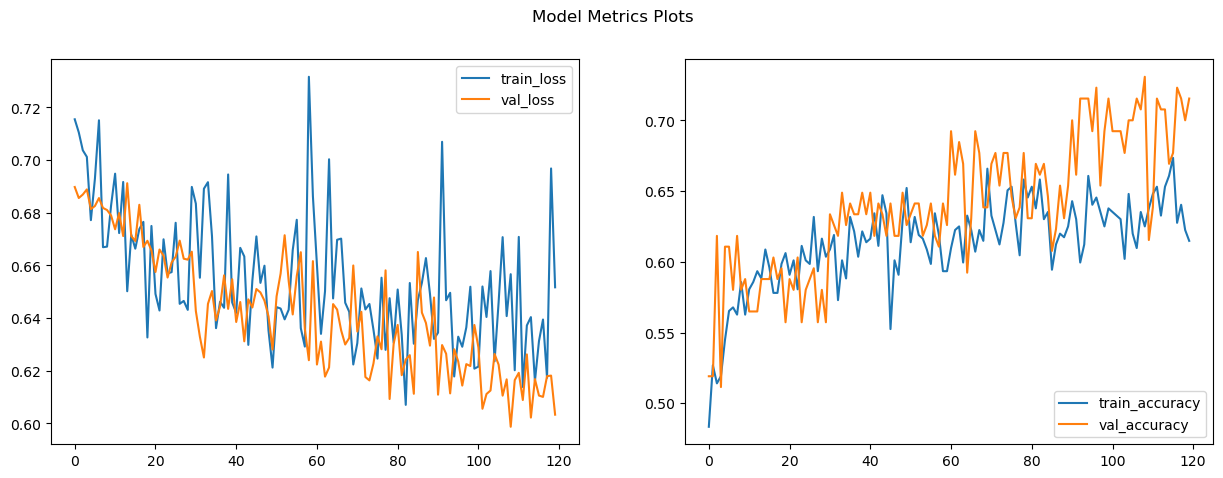

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Metrics Plots')

ax1.plot(metrics[['train_loss', 'val_loss']])
ax1.legend(['train_loss', 'val_loss'], loc="upper right")

ax2.plot(metrics[['train_accuracy', 'val_accuracy']])
ax2.legend(['train_accuracy', 'val_accuracy'], loc="lower right");

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = []
y_true = []

for data, labels in test_loader:
        data = data.to(torch.device('cuda'))
        output = model(data) # Feed Network
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

classes = ("Normal", "Autisme")

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       152
           1       0.64      0.60      0.62       169

    accuracy                           0.61       321
   macro avg       0.61      0.61      0.61       321
weighted avg       0.61      0.61      0.61       321



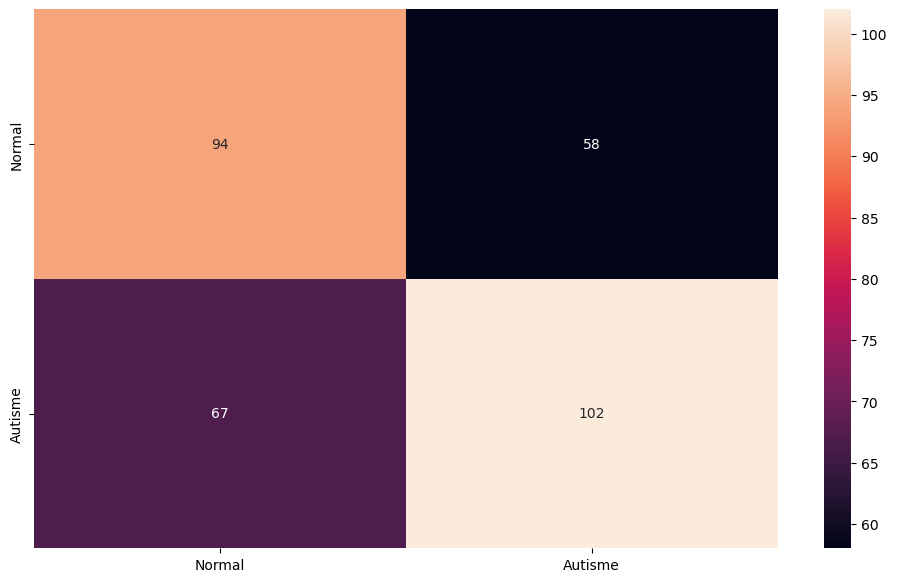

In [39]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, fmt="d",annot=True)
print(classification_report(y_true, y_pred))


In [40]:
print(classes)

('Normal', 'Autisme')
